In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.stats import gaussian_kde

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchvisionorchbearer
#from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

from tqdm import tqdm
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [208]:
mARN_df = pd.read_csv('~/Documents/Vu/AI/HumanOvarianCancerPatient2Slice2_cell_by_gene.csv')
mARN_df.drop('cell', inplace=True, axis=1)
mARN_df

,PDK4,CCL26,CX3CL1,CD4,SNAI2,TNFRSF17,ICAM3,TBX21,FAP,NFKB2,...,Blank-20,Blank-31,Blank-34,CXCR5,IL21,Blank-17,Blank-29,Blank-32,Blank-46,Blank-24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71376,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71377,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71378,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71379,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
class MyDataset(Dataset):
    """Apples Dataset"""

    def __init__(self, X, y=None, test=False):
        """
        Args:
        """
        self.test = test
        self.data = X
        
    def __len__(self):import umap
        return len(self.data)

    def __getitem__(self, idx):
        dat = self.data[idx]
        if self.test:
            return dat
        else:
            return [dat, dat]
        

In [116]:
tensor = torch.Tensor(mARN_df.values)
# tensor = tensor.reshape([71381,1,550])

dataset = MyDataset(tensor)
train_size = int(0.8 * len(tensor))  # 80% des données pour l'entraînement
test_size = len(tensor) - train_size  # 20% des données pour le test
X_train, X_test = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(X_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=64, shuffle=False)

In [216]:
class AutoEncoder(nn.Module):
    def __init__(self):
#         super(AutoEncoder, self).__init__()
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(550, 250),
            nn.ReLU(),
            nn.Linear(250, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 250),
            nn.ReLU(),
            nn.Linear(250, 550),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [217]:
model = AutoEncoder()

check_last = ModelCheckpoint('check_last.pth')
checkpoint = Best('check_best.pth', monitor='val_loss', mode='min')

trial = Trial(model,
              optim.Adam(model.parameters(), lr=5e-04), 
              nn.CrossEntropyLoss(), 
              metrics=["loss"],
              callbacks=[check_last, checkpoint])

In [221]:
trial = trial.load_state_dict(state_dict=torch.load("check_last.pth"))

trial.with_generators(train_generator=train_dataloader, 
                  val_generator=test_dataloader, 
                  test_generator=test_dataloader)


mytrial = trial.run(epochs=60, verbose=1)

 33%|###3      | 20/60 [00:00<?, ?it/s]

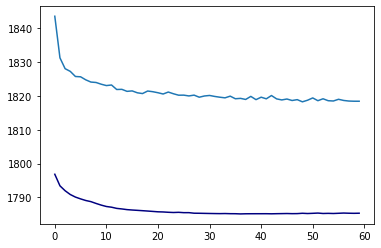

In [223]:
plt.plot([mt["loss"] for mt in mytrial], label="Train loss", color="C0")
plt.plot([mt["val_loss"] for mt in mytrial], label="Val loss", color="navy")

In [202]:
print(len(test_dataloader))
len(test_dataloader.dataset)

224


14277

In [233]:
print(len(train_dataloader))
print(test_dataloader.dataset)
len(train_dataloader.dataset)

893


57104

In [249]:
encoded_data = []

for i in tqdm(range(len(test_dataloader.dataset))):
    with torch.no_grad():
        sample = test_dataloader.dataset[i][0].unsqueeze(0)
        encoded_data.append(trial.state['model'].encoder.forward(sample).numpy()[0])

encoded_data = np.array(encoded_data)
print(encoded_data.shape)
encoded_data

100%|██████████████████████████████████| 14277/14277 [00:01<00:00, 11339.45it/s]

(14277, 10)


array([[ 4.7664313e+00, -1.1198480e+01,  5.9796596e+00, ...,
         1.9161526e+00, -8.6768752e-01,  3.2025681e+00],
       [-2.0187847e+01, -2.4408296e-02, -3.4488533e+01, ...,
        -1.2990632e+01,  1.0136535e+00, -1.2464600e+01],
       [-2.1643141e-01, -4.7277522e+00,  1.5390344e+01, ...,
         7.0844393e+00,  2.1425711e+01,  2.7167068e+00],
       ...,
       [ 9.1432867e+00, -1.5379949e-01,  1.7879223e+00, ...,
         7.5328035e+00, -1.5187552e+01, -7.3498883e+00],
       [ 5.4152794e+00, -2.7107804e+00,  1.4699898e+01, ...,
         3.5479977e+00,  7.7050724e+00,  6.2336555e+00],
       [ 8.3670597e+00, -3.5753152e+00,  7.6015058e+00, ...,
         1.0743743e+01,  3.0294468e+00, -7.1456373e-01]], dtype=float32)

In [250]:
encoded_data.shape

(14277, 10)

In [286]:
reducer = umap.UMAP(random_state=42)
coordsUMAP = reducer.fit_transform(np.array(encoded_data))

In [287]:
# PCA method
pca = PCA(n_components=2)
coordsPCA = pca.fit_transform(encoded_data)

In [293]:
encoded_data.shape

(14277, 10)

In [289]:
# PCA method
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coordsTSNE = tsne.fit_transform(encoded_data)

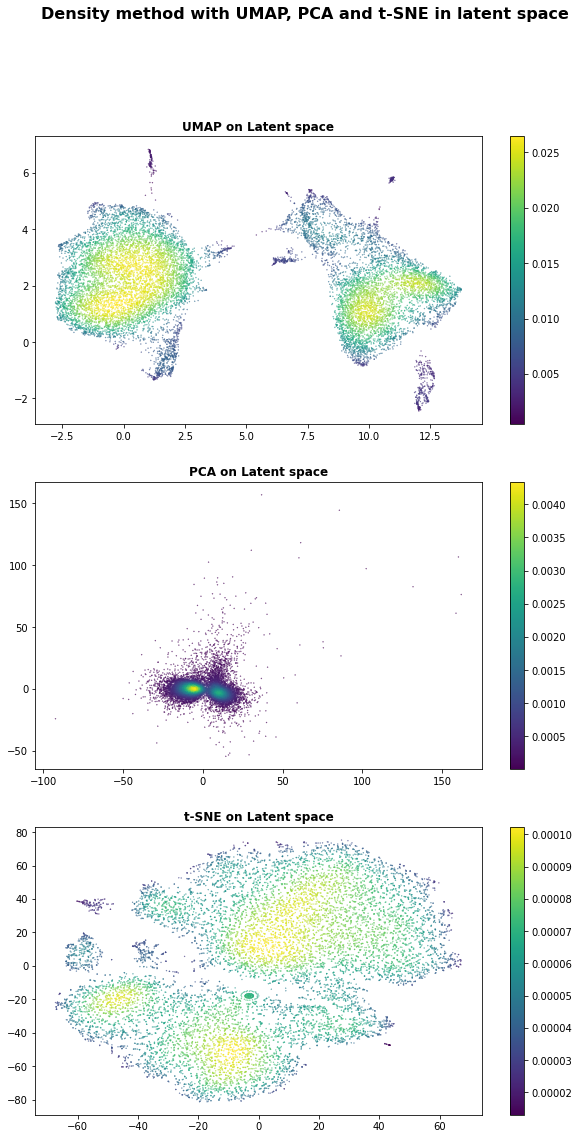

In [294]:
kde = gaussian_kde(coordsUMAP.T)
density_umap = kde(coordsUMAP.T)
kde = gaussian_kde(coordsPCA.T)
density_pca = kde(coordsPCA.T)
kde = gaussian_kde(coordsTSNE.T)
density_tsne = kde(coordsTSNE.T)

fig, axes = plt.subplots(3,1, figsize=(10,18))
fig.suptitle('Density method with UMAP, PCA and t-SNE in latent space', fontsize=16, fontweight="bold")
axes[0].set_title("UMAP on Latent space", fontweight="bold")
scatter_umap = axes[0].scatter(embedding[:,0], embedding[:,1], c=density_umap, cmap='viridis', s=0.1)
fig.colorbar(scatter_umap, ax=axes[0])

axes[1].set_title("PCA on Latent space", fontweight="bold")
scatter_pca = axes[1].scatter(coordsPCA[:, 0], coordsPCA[:, 1], c=density_pca, cmap='viridis', s=0.1)
fig.colorbar(scatter_pca, ax=axes[1])

axes[2].set_title("t-SNE on Latent space", fontweight="bold")
scatter_tsne = axes[2].scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=density_tsne, cmap='viridis', s=0.1)
fig.colorbar(scatter_tsne, ax=axes[2])

plt.show()

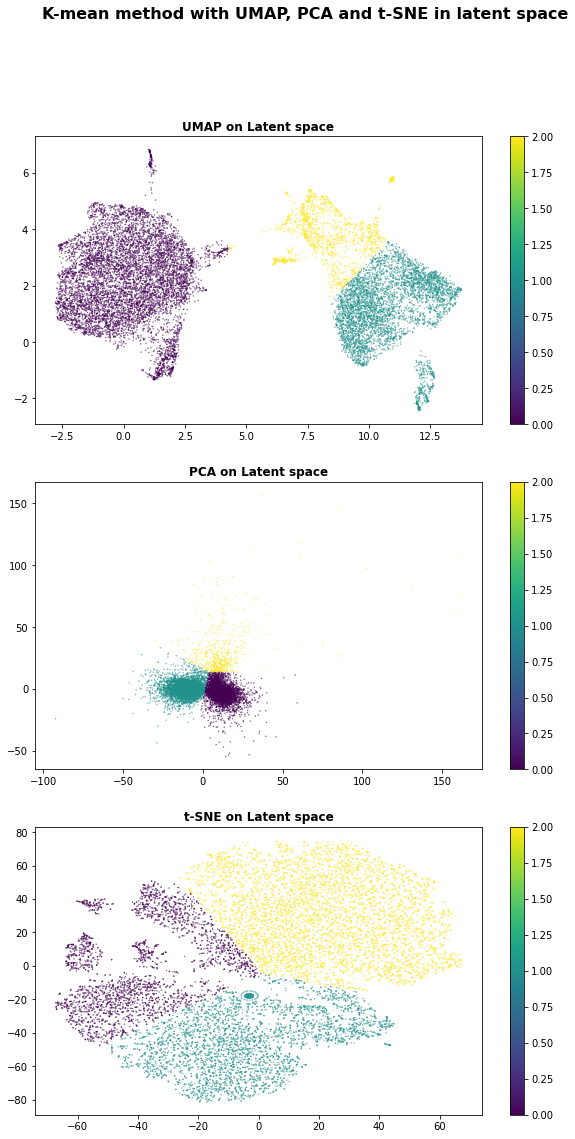

In [306]:
k = 3
kmeans = KMeans(n_clusters=k)
labels_UMAP = kmeans.fit_predict(coordsUMAP)
labels_PCA = kmeans.fit_predict(coordsPCA)
labels_TSNE = kmeans.fit_predict(coordsTSNE)


fig, axes = plt.subplots(3,1, figsize=(10,18))
fig.suptitle('K-mean method with UMAP, PCA and t-SNE in latent space', fontsize=16, fontweight="bold")
axes[0].set_title("UMAP on Latent space", fontweight="bold")
scatter_umap = axes[0].scatter(embedding[:,0], embedding[:,1], c=labels_UMAP, cmap='viridis', s=0.1)
fig.colorbar(scatter_umap, ax=axes[0])

axes[1].set_title("PCA on Latent space", fontweight="bold")
scatter_pca = axes[1].scatter(coordsPCA[:, 0], coordsPCA[:, 1], c=labels_PCA, cmap='viridis', s=0.1)
fig.colorbar(scatter_pca, ax=axes[1])

axes[2].set_title("t-SNE on Latent space", fontweight="bold")
scatter_tsne = axes[2].scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=labels_TSNE, cmap='viridis', s=0.1)
fig.colorbar(scatter_tsne, ax=axes[2])

plt.show()